In [1]:
import xmltodict
import glob
from os.path import join
from skimage.draw import rectangle_perimeter
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from cnn import CNN
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision      
import matplotlib.pyplot as plt
XML_PATH = 'F:\\computer vision term project\\VOC2007\Annotations\\'
image_path = 'F:\\computer vision term project\\JPEGImages\\'
xml_files = glob.glob(os.path.join(XML_PATH, '*.xml'))
images = glob.glob(os.path.join(image_path, '*.jpg'))

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=80000, out_features=2, bias=True)
)


In [2]:
def bbox_to_numpy(bbox):
    box = np.array([[bbox['xmin'], bbox['xmax']], 
                 [bbox['ymin'], bbox['ymax']]
                ])  
    return box.astype(int)

def read_annotation_xml(fname):
    with open (fname, "r") as file:
        xml = file.readlines()
    annotation_dict = xmltodict.parse(''.join(xml))
    try:
      return [bbox_to_numpy(x['bndbox']) for x in annotation_dict['annotation']['object']]
    except TypeError:
      return [bbox_to_numpy(annotation_dict['annotation']['object']['bndbox'])]
def get_pair(filename_xml, filename_img):
    image = cv2.imread(filename_img)
    if ((image.shape[0] > 2000)&(image.shape[1] > 2000)):
      imageLAB = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)[:, :, 1]
      annotations = read_annotation_xml(filename_xml)
      return imageLAB, annotations

def get_train_sample(level='levle2', ratio=1):
    files_xml = [idx for idx in xml_files if idx[:len(XML_PATH) + 6] == XML_PATH + level] 
    files_img = [idx for idx in images if idx[:len(image_path) + 6] == image_path + level]

    files_xml.sort()
    files_img.sort()

    files_xml = files_xml[:int(len(files_xml)*ratio)]
    files_img = files_img[:int(len(files_img)*ratio)]

    return [get_pair(i, j) for i, j in zip(files_xml, files_img)]

    
def plot_frame(image, bboxes, figsize=(10, 10), c=None):
    plt.figure(figsize=figsize)
    for bbox in bboxes:
        plt.plot(*rectangle_perimeter(bbox[:, 0], bbox[:, 1]), c=c)
    plt.imshow(image,cmap='gray')
    plt.axis('off')

def get_positive_patches(image, bboxes, width, height):
  patches = []
  for bbox in bboxes:
    x_min = (bbox[1, 0] + bbox[1, 1] - width)//2
    x_max = (bbox[1, 0] + bbox[1, 1] + width)//2
    y_min = (bbox[0, 0] + bbox[0, 1] - height)//2
    y_max = (bbox[0, 0] + bbox[0, 1] + height)//2
    if (x_min >= 0 and y_min >= 0 and 
        x_max <= image.shape[0] and
        y_min <= image.shape[1]):
      patches.append(image[x_min:x_max, y_min:y_max])
  return patches
def get_negative_patches(image, width, height, n_patches):
      patches = []
      for i in range(n_patches):
        x_0 = np.random.randint(0, image.shape[0] - width)
        y_0 = np.random.randint(0, image.shape[1] - height)
      patches.append(image[x_0:x_0 + width, y_0:y_0 + height])
      return patches

def non_max_suppression(bboxes, overlapThresh):
  
  if len(bboxes) == 0:
    return []

  new_bboxes = np.ones((1, 4))

  for bbox in bboxes:
    new_bboxes = np.vstack([new_bboxes, np.array([[bbox[1, 0], bbox[0, 0], bbox[1, 1], bbox[0, 1]]])])
  new_bboxes = new_bboxes[1:]

  if new_bboxes.dtype.kind == "i":
    new_bboxes = new_bboxes.astype("float")
  pick = []

  x1 = new_bboxes[:,0]
  y1 = new_bboxes[:,1]
  x2 = new_bboxes[:,2]
  y2 = new_bboxes[:,3]

  area = (x2 - x1 + 1) * (y2 - y1 + 1)
  idxs = np.argsort(y2)

  while len(idxs) > 0:

    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)

    xx1 = np.maximum(x1[i], x1[idxs[:last]])
    yy1 = np.maximum(y1[i], y1[idxs[:last]])
    xx2 = np.minimum(x2[i], x2[idxs[:last]])
    yy2 = np.minimum(y2[i], y2[idxs[:last]])
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    overlap = (w * h) / area[idxs[:last]]

    idxs = np.delete(idxs, np.concatenate(([last],
      np.where(overlap > overlapThresh)[0])))
  new_bboxes = new_bboxes[pick].astype("int")
  
  bboxes = []
  for arr in new_bboxes:
    bboxes.append(np.array([[arr[1], arr[3]],
                            [arr[0], arr[2]]]))

  return bboxes


In [3]:
data_level1 = get_train_sample(level='levle1',ratio=0.15)
data_level2 = get_train_sample(level='levle2')
data_level3 = get_train_sample(level='levle3')


In [4]:
data_level1 = [x for x in data_level1 if x is not None]
data_level2 = [x for x in data_level2 if x is not None]
data_level3 = [x for x in data_level3 if x is not None]

data = data_level1.copy()
data.extend(data_level2)
data.extend(data_level3)

In [5]:
len(data)

257

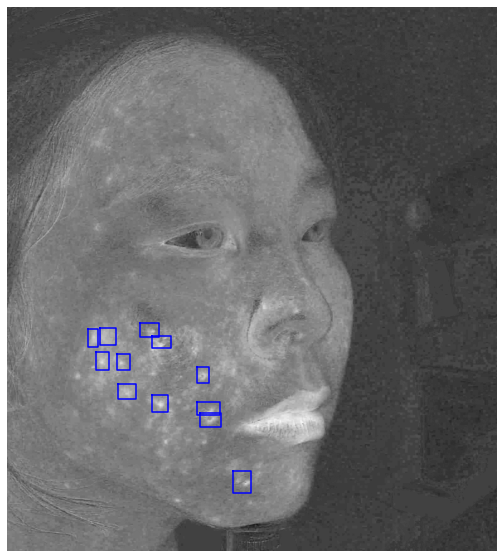

In [6]:
i = 76
plot_frame(data[i][0],data[i][1], c='b')

In [7]:
patch_size_x = 200
patch_size_y = 200

image_pos = []
for images, bboxes in data:
  image_pos.extend(get_positive_patches(images, bboxes, patch_size_x, patch_size_y))

mean_num_of_acne = len(image_pos)//len(data)

image_neg = []
for images, bboxes in data:
  image_neg.extend(get_negative_patches(images, patch_size_x, patch_size_y, mean_num_of_acne))

(-0.5, 199.5, 199.5, -0.5)

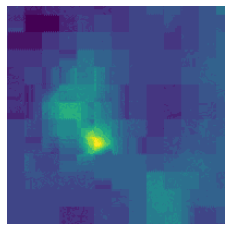

In [8]:
img=plt.imshow(image_pos[105])
plt.axis('off')

In [9]:
a=image_pos[1]

In [10]:
to_remove = []
for i, img in enumerate(image_pos):
  if ((img.shape[0] != patch_size_x)|(img.shape[1] != patch_size_y)):
    to_remove.append(i)
image_pos = [i for j, i in enumerate(image_pos) if j not in to_remove]

all_images = image_pos.copy()
all_images.extend(image_neg)
len(image_pos), len(image_neg), len(all_images)

(5609, 257, 5866)

In [11]:
X = np.array([hog(img, orientations=8, pixels_per_cell=(20, 20), cells_per_block=(2, 2)) for img in all_images])
y = np.concatenate([np.ones(len(image_pos)), np.zeros(len(image_neg))])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

KeyboardInterrupt: 

In [11]:
clf = SVC(kernel='poly', probability=True, random_state=1)
clf.fit(X_train, y_train)

SVC(kernel='poly', probability=True, random_state=1)

In [12]:
print(X.shape,y.shape)

(5866, 2592) (5866,)


In [13]:
joblib.dump(clf, 'svm_weights.joblib')
clf = joblib.load('svm_weights.joblib')

In [14]:
print('Train accuracy: {:.3}'.format(accuracy_score(y_train, clf.predict(X_train))))
print('Test accuracy: {:.3}'.format(accuracy_score(y_test, clf.predict(X_test))))

Train accuracy: 0.98
Test accuracy: 0.965


In [26]:
q = torch.tensor([[1, 2, 3, 4],[1,2,3,4]])
q1=torch.unsqueeze(q,dim=1).type(torch.FloatTensor)
q1.shape

torch.Size([2, 1, 4])

In [11]:
cnn=CNN()

In [12]:
x1=np.array(all_images)
y1 = np.concatenate([np.ones(len(image_pos)), np.zeros(len(image_neg))])
x=torch.from_numpy(x1)
y=torch.from_numpy(y1)
test_x = torch.unsqueeze(x, dim=1).type(torch.FloatTensor)[:20]/255
y=y[:20]
cnn(test_x[0])

f:\computer vision term project\cnn.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output1=m(output)


tensor([[0.4878, 0.5122]], grad_fn=<SoftmaxBackward0>)

In [24]:
a=cnn(test_x[0])
pred_y = torch.max(a, 1)[1].data.numpy().squeeze()
pred_y

array(1, dtype=int64)

In [13]:
torch_dataset = Data.TensorDataset(test_x, y)
train_loader = Data.DataLoader(dataset=torch_dataset, batch_size=1, shuffle=True)

In [14]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [16]:
for epoch in range(1):
    for step, (b_x, b_y) in enumerate(train_loader):   
        output = cnn(b_x[0])               
        loss = loss_func(output, b_y.long())   
        optimizer.zero_grad()           
        loss.backward()               
        optimizer.step()   


In [21]:
a=cnn(test_x[3])
a

f:\computer vision term project\cnn.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output1=m(output)


tensor([[6.2220e-36, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)

In [23]:
conv1=nn.Sequential(nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5,stride=1,padding=2),nn.ReLU(),nn.MaxPool2d(kernel_size=2))
conv2=nn.Sequential(nn.Conv2d(16,32,5,1,2),nn.ReLU(),nn.MaxPool2d(2)) 

In [25]:
a=conv1(test_x[0])
a1=conv2(a)
a2=a1.view(a1.size(0),-1)
a2.shape

torch.Size([32, 2500])

In [50]:
input = torch.randn(2)
m=nn.Softmax()
output=m(input)
output

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9600\1658330660.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output=m(input)


tensor([0.4582, 0.5418])

In [44]:
nn.Softmax(input)

Softmax(dim=tensor([0.1983, 2.3174]))